# Fashion Product Recommendation using Multimodal Data

In [43]:
import pathlib 
import os
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np 
import pandas as pd 
import joblib
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from pandas.core.common import flatten
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [44]:
DATASET_PATH = "/home/arj/TriSem3/CaseStudy/DatasetCaseStudy/"
print(os.listdir(DATASET_PATH))

['styles.csv', 'images', 'myntradataset']


In [48]:
df = pd.read_csv(DATASET_PATH + 'styles.csv',on_bad_lines="skip")

#top 10 rows
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


In [49]:
%%time
import os

def get_all_filenames(directory):
    """
    Returns a set of all filenames in the given directory.
    """
    filenames = {entry.name for entry in os.scandir(directory) if entry.is_file()}
    return filenames

images = get_all_filenames(DATASET_PATH + "images/")

CPU times: user 24.8 ms, sys: 27.9 ms, total: 52.7 ms
Wall time: 51.4 ms


In [50]:
def check_image_exists(image_filename):
    """
    Checks if the desired filename exists within the filenames found in the given directory.
    Returns True if the filename exists, False otherwise.
    """
    global images
    if image_filename in images:
        return image_filename
    else:
        return np.nan

df['image'] = df["id"].apply(lambda image: check_image_exists(str(image) + ".jpg"))
df = df.reset_index(drop=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [53]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()

#image path 
def image_location(img):
    return '/home/arj/TriSem3/CaseStudy/DatasetCaseStudy/images/'  + img

# function to load image
def import_img(image):
    image = cv2.imread(image_location(image))
    return image

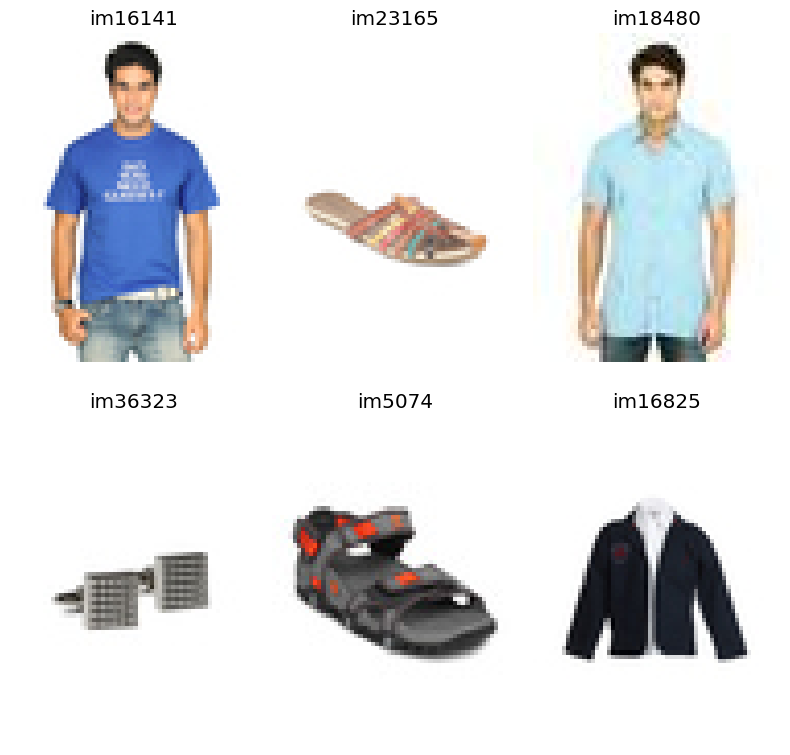

In [54]:
# generation of a dictionary of (title, images)
figures = {'im'+str(i): import_img(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures,2,3)

<Axes: ylabel='articleType'>

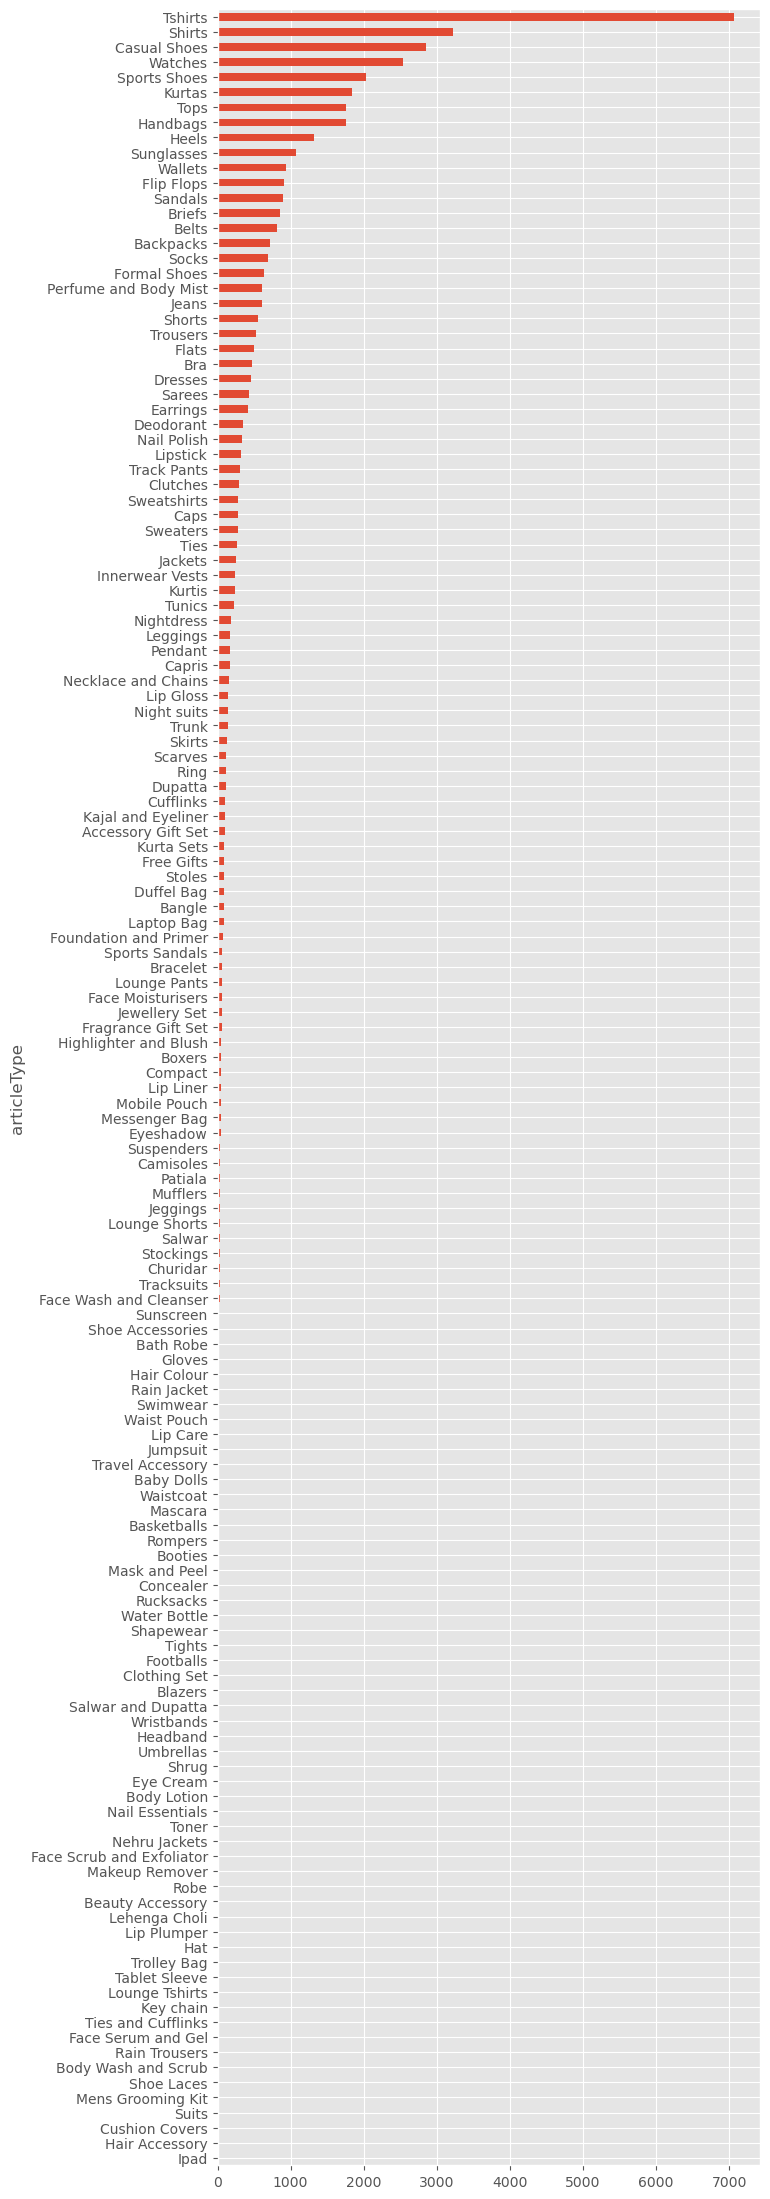

In [55]:
# Understanding the data, how many different articleType are present and knowing their frequency
plt.figure(figsize=(7,28))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [56]:
#ResNet18 PyTorch model to convert

# I will use resent architecture for our work as the name suggest it has 18 layers altogether ith layers of convolution in it
# It has been trained on million of images that are extracted from imagenet dataset it has capacity to classify over 1000 class objects
# Defining the input shape

width= 224
height= 224

# Loading the pretrained model
resnetmodel = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = resnetmodel._modules.get('avgpool')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/arj/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 9.45MB/s]


In [58]:
#evaluate the model
resnetmodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
# scaling the data
s_data = transforms.Resize((224, 224))

#normalizing
standardize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# converting to tensor
convert_tensor = transforms.ToTensor()

In [60]:
#function to get embeddings
def vector_extraction(resnetmodel, image_id):    
    # Using concept of exception handling to ignore missing images
    try: 
        # 1. Load the image with Pillow library
        img = Image.open(image_location(image_id)).convert('RGB')
        
        # 2. Create a PyTorch Variable with the transformed image
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
        
        # 3. Create a vector of zeros that will hold our feature vector
        # The 'avgpool' layer has an output size of 512
        embeddings = torch.zeros(512)
        
        # 4. Define a function that will copy the output of a layer
        def copy_data(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))
            
        # 5. Attach that function to our selected layer
        hlayer = layer.register_forward_hook(copy_data)
        
        # 6. Run the model on our transformed image
        resnetmodel(t_img)
        
        # 7. Detach our copy function from the layer
        hlayer.remove()
        emb = embeddings
        
        # 8. Return the feature vector
        return embeddings
    
    # If file not found
    except FileNotFoundError:
        # Store the index of such entries in missing_img list and drop them later
        missed_img = df[df['image']==image_id].index
        print(missed_img)
        missing_img.append(missed_img)

In [61]:
# Testing if our vector_extraction function works well on sample image
sample_embedding_0 = vector_extraction(resnetmodel, df.iloc[0].image)

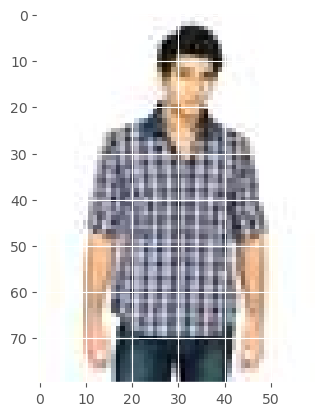

In [62]:
# Plotting the sample image and its embeddings
img_array = import_img(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))

In [63]:
df.shape

(44424, 11)

In [65]:
%%time
import swifter
# Applying embeddings on subset of this huge dataset
df_embeddings = df[:5000] #We can apply on entire df, like: df_embeddings = df

#looping through images to get embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))

#convert to series
df_embs        = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 512)
CPU times: user 34min 49s, sys: 9.49 s, total: 34min 58s
Wall time: 9min 57s


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.016732,0.983267,0.040268,0.113140,0.205126,1.246753,0.035904,0.336803,1.327888,0.480529,...,0.584026,0.483292,1.229778,0.738920,0.000000,0.035314,1.740417,0.887334,0.004988,0.036427
1,0.034120,0.804465,0.071094,0.286108,0.118644,0.485673,0.767113,0.116924,1.131223,1.229429,...,0.125503,0.554490,0.160279,0.211642,0.000000,0.921631,1.210376,0.750111,0.015514,0.182356
2,0.306779,0.196791,2.325818,0.337869,0.206403,0.410262,2.865744,0.493546,2.894568,3.824196,...,0.377007,3.216576,2.293661,1.343940,1.047547,0.016881,2.759721,0.630303,0.114623,0.002224
3,0.052566,0.312828,0.318465,0.045758,0.207992,0.486139,0.871359,0.437957,0.861973,1.257671,...,0.000401,0.126220,0.117900,0.174461,0.000000,0.004943,1.039022,0.150581,0.009435,0.015909
4,0.146032,0.624985,0.023857,0.201500,0.273301,2.073840,0.038832,0.537267,1.338017,0.428539,...,0.039452,1.069758,0.774631,0.874319,0.000000,0.010583,2.638507,0.303630,0.005840,0.026666


In [66]:
#export the embeddings 
df_embs.to_csv('/home/arj/TriSem3/CaseStudy/DatasetCaseStudy/working/df_embs.csv')

# importing the embeddings  
df_embs = pd.read_csv('/home/arj/TriSem3/CaseStudy/DatasetCaseStudy/working/df_embs.csv')
df_embs.drop(['Unnamed: 0'],axis=1,inplace=True)
df_embs.dropna(inplace=True)

In [67]:
#exporting as pkl
joblib.dump(df_embs, '/home/arj/TriSem3/CaseStudy/DatasetCaseStudy/working/df_embs.pkl', 9)

#importing the pkl
df_embs = joblib.load('/home/arj/TriSem3/CaseStudy/DatasetCaseStudy/working/df_embs.pkl')

In [68]:
# Calculating similarity between images ( using embedding values )
cosine_sim = cosine_similarity(df_embs) 

# Previewing first 4 rows and 4 columns similarity just to check the structure of cosine_sim
cosine_sim[:4, :4]

array([[1.        , 0.76683546, 0.54555205, 0.77950721],
       [0.76683546, 1.        , 0.49617081, 0.88492663],
       [0.54555205, 0.49617081, 1.        , 0.52310666],
       [0.77950721, 0.88492663, 0.52310666, 1.        ]])

In [69]:
# Storing the index values in a series index_vales for recommending
index_vales = pd.Series(range(len(df)), index=df.index)
index_vales

# Defining a function that gives recommendations based on the cosine similarity score
def recomend_images(ImId, df, top_n = 6):
    # Assigning index of reference into sim_ImId
    sim_ImId    = index_vales[ImId]
    # Storing cosine similarity of all other items with item requested by user in sim_scores as a list
    sim_scores = list(enumerate(cosine_sim[sim_ImId]))
    # Sorting the list of sim_scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Extracting the top n values from sim_scores
    sim_scores = sim_scores[1:top_n+1]
    # ImId_rec will return the index of similar items
    ImId_rec    = [i[0] for i in sim_scores]
    # ImId_sim will return the value of similarity score
    ImId_sim    = [i[1] for i in sim_scores]
    return index_vales.iloc[ImId_rec].index, ImId_sim
# Sample given below
recomend_images(3810, df, top_n = 5)

(Index([2400, 3899, 3678, 4818, 2354], dtype='int64'),
 [0.9632298247659683,
  0.9571409952570421,
  0.9557428268967693,
  0.953964011732056,
  0.95376994011689])

Visualizing the Recommendations

In [70]:
def Rec_viz_image(input_imageid): 

    # Getting recommendations
    idx_rec, idx_sim = recomend_images(input_imageid, df, top_n = 6)
    
    # Printing the similarity score
    print (idx_sim)
    
    # Plotting the image of item requested by user
    plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))

    # Generating a dictionary of { index, image }
    figures = {'im'+str(i): import_img(row.image) for i, row in df.loc[idx_rec].iterrows()}
    
    # Plotting the similar images in a figure, with 2 rows and 3 columns
    plot_figures(figures, 2, 3)

[0.9612716167186675, 0.9545388843696196, 0.9507643122174784, 0.9496367545969635, 0.9486184801120798, 0.9477646543836764]


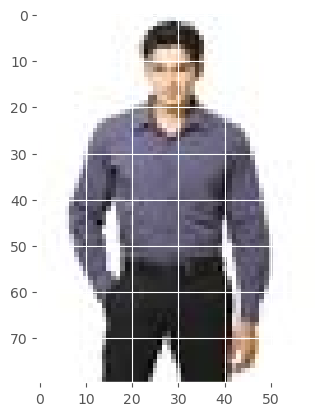

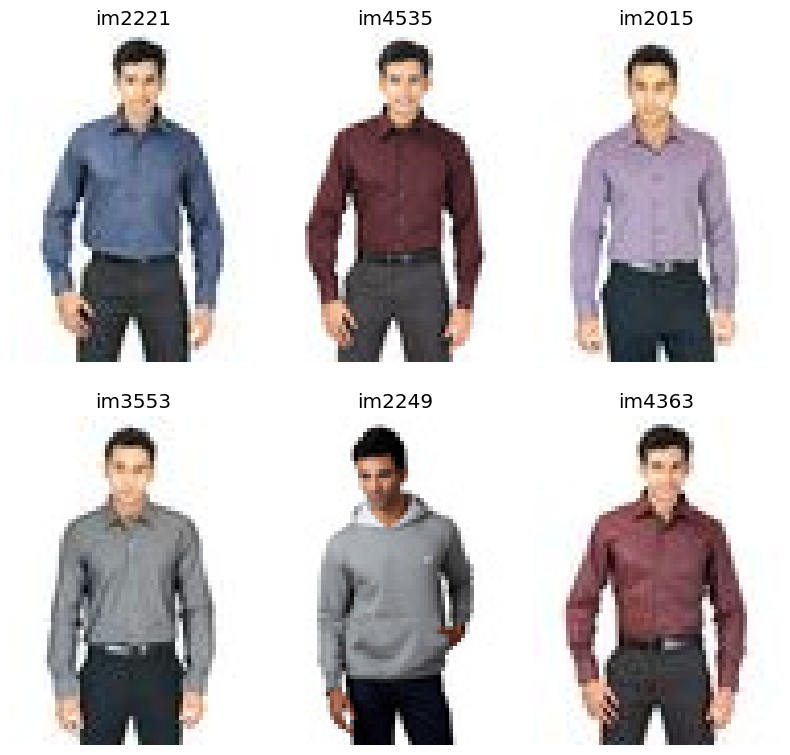

In [71]:
Rec_viz_image(3510)

[0.7816826130204462, 0.7782090137039399, 0.7769141399823134, 0.7765189736181841, 0.7749759482300096, 0.7736784838049001]


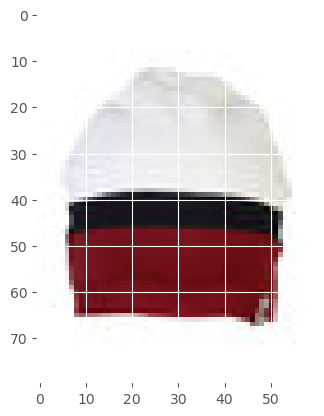

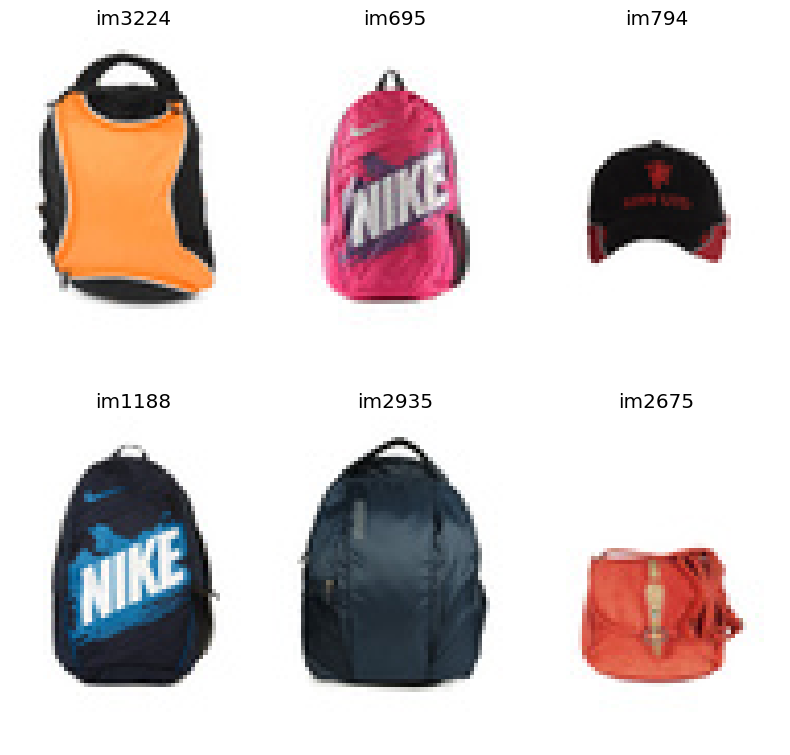

In [72]:
Rec_viz_image(2002)